In [2]:
# Cell 1: Import libraries & konfigurasi
import os
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
# Lokasi file kamu
DATA_DIR = r"C:\Users\Lenovo\Documents\sisrekpraktikum\data-books"

# Nama file
TRAIN_FILE = "train.csv"
TARGET_USERS_FILE = "data_target_users_test.csv"
SAMPLE_SUB_FILE = "sample_submission.csv"

# Parameter model - UPDATED untuk performa lebih baik
N_RECS = 10
ALS_ON = True                # aktifkan ALS

# === PARAMETER UPDATED FOR BETTER PERFORMANCE ===
# Previous params were too conservative for beating IBCF
ALS_FACTORS = 48             # increased from 16 → 48 (3x capacity)
ALS_ITER = 8                 # increased from 5 → 8 (better convergence)
ALS_REG = 0.05               # decreased from 0.1 → 0.05 (less constraint)
ALS_ALPHA = 40               # increased from 20 → 40 (stronger confidence)

print("🚀 Parameter UPDATED untuk meningkatkan performa ALS:")
print(f"   - Factors: {ALS_FACTORS} (increased from 16 for more capacity)")
print(f"   - Iterations: {ALS_ITER} (increased from 5 for convergence)")  
print(f"   - Regularization: {ALS_REG} (decreased from 0.1 for less constraint)")
print(f"   - Alpha: {ALS_ALPHA} (increased from 20 for implicit feedback)")
print(f"\n💡 Goal: Beat IBCF MAP@10 = 0.010915")

# df = pd.read_csv("train.csv")
# df.head(10)

🚀 Parameter UPDATED untuk meningkatkan performa ALS:
   - Factors: 48 (increased from 16 for more capacity)
   - Iterations: 8 (increased from 5 for convergence)
   - Regularization: 0.05 (decreased from 0.1 for less constraint)
   - Alpha: 40 (increased from 20 for implicit feedback)

💡 Goal: Beat IBCF MAP@10 = 0.010915


In [4]:
# Cell 2: Load data
train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_FILE))
test_users = pd.read_csv(os.path.join(DATA_DIR, TARGET_USERS_FILE))
sample_sub = pd.read_csv(os.path.join(DATA_DIR, SAMPLE_SUB_FILE))

print("Train shape:", train.shape)
print("Test users shape:", test_users.shape)
print("Sample submission shape:", sample_sub.shape)
train.head()

Train shape: (269764, 2)
Test users shape: (13876, 1)
Sample submission shape: (2, 2)


,user_id,item_id
0,8,0002005018
1,8,074322678X
2,8,0887841740
3,8,1552041778
4,8,1567407781


In [5]:
# Cell 3: Preprocessing & encoding
def infer_columns(df):
    cols = df.columns.tolist()
    user_col = None
    item_col = None
    for c in cols:
        if "user" in c.lower(): user_col = c
        if "item" in c.lower(): item_col = c
    return user_col, item_col

u_col, i_col = infer_columns(train)
train['rating'] = 1  # implicit
train = train[[u_col, i_col, 'rating']].rename(columns={u_col:'user', i_col:'item'})

# Encode id
user_enc = LabelEncoder()
item_enc = LabelEncoder()
train['uidx'] = user_enc.fit_transform(train['user'])
train['iidx'] = item_enc.fit_transform(train['item'])

n_users = train['uidx'].nunique()
n_items = train['iidx'].nunique()
print(f"Total users: {n_users}, Total items: {n_items}")

# Sparse matrix user-item
R = sparse.csr_matrix((train['rating'], (train['uidx'], train['iidx'])), shape=(n_users, n_items))
print("Shape matriks user-item:", R.shape)

Total users: 13876, Total items: 123069
Shape matriks user-item: (13876, 123069)


In [6]:
# Cell 4: Define functions

# 1. Popularity baseline
def popularity_recommend(R, user_idx, N=10, exclude_seen=True):
    item_pop = np.array(R.sum(axis=0)).ravel()
    if exclude_seen and user_idx is not None:
        seen = set(R[user_idx].nonzero()[1])
        candidates = [(i, p) for i,p in enumerate(item_pop) if i not in seen]
    else:
        candidates = list(enumerate(item_pop))
    return [i for i,_ in sorted(candidates, key=lambda x: -x[1])[:N]]

In [7]:
# 2. Item-Based Collaborative Filtering (Memory Optimized)
def item_based_recommend(R, user_idx, N=10):
    """
    Memory-optimized IBCF with better error handling
    """
    if user_idx is None:
        # Fallback ke popularity untuk cold-start users
        item_pop = np.array(R.sum(axis=0)).ravel()
        return np.argsort(-item_pop)[:N].tolist()
    
    # Get user's interaction history
    user_items = R[user_idx].nonzero()[1]
    
    if len(user_items) == 0:
        # User tanpa history -> fallback ke popularity
        return popularity_recommend(R, user_idx, N)
    
    try:
        # Transpose matrix (item-user)
        Iu = R.T.tocsr()
        
        # Aggregate user profile dari items yang pernah diinteract
        profile = Iu[user_items].sum(axis=0)
        profile = np.asarray(profile).ravel()
        
        # Compute item norms (untuk normalisasi cosine similarity)
        item_norms = np.sqrt(Iu.multiply(Iu).sum(axis=1)).A1 + 1e-9
        profile_norm = np.linalg.norm(profile) + 1e-9
        
        # Compute similarity scores (cosine similarity)
        # Gunakan sparse matrix multiplication untuk efisiensi
        scores = Iu.dot(profile) / (item_norms * profile_norm)
        scores = np.asarray(scores).ravel()
        
        # Exclude items yang sudah pernah dilihat user
        scores[list(user_items)] = -np.inf
        
        # Get top N items
        # Gunakan argpartition untuk efisiensi jika N << total items
        if N < len(scores) // 2:
            # Lebih efisien untuk N kecil
            top_indices = np.argpartition(-scores, min(N, len(scores)-1))[:N]
            top_indices = top_indices[np.argsort(-scores[top_indices])]
        else:
            top_indices = np.argsort(-scores)[:N]
        
        return top_indices.tolist()
        
    except (MemoryError, Exception) as e:
        # Jika terjadi error, fallback ke popularity
        print(f"⚠️  IBCF error for user {user_idx}: {str(e)[:50]}... Fallback to popularity")
        return popularity_recommend(R, user_idx, N)

In [8]:
# 2a. Alternative: Simplified IBCF (Ultra Memory Efficient)
def item_based_recommend_lite(R, user_idx, N=10):
    """
    Lightweight version untuk dataset besar
    Menggunakan pendekatan simplified tanpa full similarity computation
    """
    if user_idx is None or user_idx >= R.shape[0]:
        item_pop = np.array(R.sum(axis=0)).ravel()
        return np.argsort(-item_pop)[:N].tolist()
    
    # Get items yang pernah diinteract user ini
    user_items = R[user_idx].nonzero()[1]
    
    if len(user_items) == 0:
        return popularity_recommend(R, user_idx, N)
    
    # Hitung co-occurrence: items yang sering muncul dengan items user
    # Ini lebih memory efficient daripada full similarity matrix
    item_scores = np.zeros(R.shape[1], dtype=np.float32)
    
    # Untuk setiap item yang user pernah interact
    for item_idx in user_items:
        # Cari users lain yang juga interact dengan item ini
        similar_users = R[:, item_idx].nonzero()[0]
        
        # Aggregate items dari similar users
        if len(similar_users) > 0:
            # Limit jumlah similar users untuk memory efficiency
            if len(similar_users) > 100:
                similar_users = np.random.choice(similar_users, 100, replace=False)
            
            # Count co-occurrences
            for su in similar_users:
                user_items_su = R[su].nonzero()[1]
                for ui in user_items_su:
                    if ui not in user_items:  # Exclude already seen
                        item_scores[ui] += 1.0
    
    # Exclude already seen items
    item_scores[list(user_items)] = -np.inf
    
    # Get top N
    if N < len(item_scores) // 2:
        top_idx = np.argpartition(-item_scores, min(N, len(item_scores)-1))[:N]
        top_idx = top_idx[np.argsort(-item_scores[top_idx])]
    else:
        top_idx = np.argsort(-item_scores)[:N]
    
    return top_idx.tolist()


print("✅ Alternative IBCF functions defined:")
print("   - item_based_recommend(): Optimized with error handling")
print("   - item_based_recommend_lite(): Ultra lightweight for large datasets")

✅ Alternative IBCF functions defined:
   - item_based_recommend(): Optimized with error handling
   - item_based_recommend_lite(): Ultra lightweight for large datasets


In [9]:
# 3. Implicit ALS (Alternating Least Squares)
def implicit_als(R_csr, factors=20, regularization=0.1, alpha=40, iterations=10):
    users, items = R_csr.shape
    X = np.random.normal(scale=0.01, size=(users, factors))
    Y = np.random.normal(scale=0.01, size=(items, factors))
    I_f = np.eye(factors)
    R_csr = R_csr.tocsr()

    for it in range(iterations):
        print(f"ALS iteration {it+1}/{iterations}")
        YtY = Y.T @ Y + regularization * I_f
        for u in range(users):
            start, end = R_csr.indptr[u], R_csr.indptr[u+1]
            item_idxs = R_csr.indices[start:end]
            if len(item_idxs) == 0:
                continue
            Cu = 1.0 + alpha * R_csr.data[start:end]
            Pu = np.ones_like(Cu)
            Y_i = Y[item_idxs]
            A = YtY + (Y_i.T * (Cu - 1)).dot(Y_i)
            b = (Y_i.T * Cu).dot(Pu)
            X[u] = np.linalg.solve(A, b)
        XtX = X.T @ X + regularization * I_f
        R_csc = R_csr.tocsc()
        for i in range(items):
            start, end = R_csc.indptr[i], R_csc.indptr[i+1]
            user_idxs = R_csc.indices[start:end]
            if len(user_idxs) == 0:
                continue
            Ci = 1.0 + alpha * R_csc.data[start:end]
            Pi = np.ones_like(Ci)
            X_u = X[user_idxs]
            A = XtX + (X_u.T * (Ci - 1)).dot(X_u)
            b = (X_u.T * Ci).dot(Pi)
            Y[i] = np.linalg.solve(A, b)
    return X, Y

In [10]:
# 3a. Optimized Implicit ALS dengan batching dan progress tracking
def implicit_als_optimized(R_csr, factors=16, regularization=0.1, alpha=20, iterations=5, batch_size=1000):
    """
    Optimized version dengan:
    - Reduced factors (16 vs 32)
    - Lower alpha (20 vs 40) 
    - Fewer iterations (5 vs 8)
    - Batch processing untuk user/item updates
    - Better progress tracking
    """
    import time
    
    users, items = R_csr.shape
    print(f"Dataset size: {users} users × {items} items")
    print(f"Sparsity: {100 * (1 - R_csr.nnz / (users * items)):.2f}%")
    
    # Initialize dengan variance yang lebih kecil untuk stabilitas
    X = np.random.normal(scale=0.005, size=(users, factors))
    Y = np.random.normal(scale=0.005, size=(items, factors))
    I_f = np.eye(factors)
    R_csr = R_csr.tocsr()

    for it in range(iterations):
        start_time = time.time()
        print(f"\n--- ALS Iteration {it+1}/{iterations} ---")
        
        # Update users
        print("Updating user factors...")
        YtY = Y.T @ Y + regularization * I_f
        for u in tqdm(range(users), desc="Users", leave=False):
            start, end = R_csr.indptr[u], R_csr.indptr[u+1]
            item_idxs = R_csr.indices[start:end]
            if len(item_idxs) == 0:
                continue
            Cu = 1.0 + alpha * R_csr.data[start:end]
            Pu = np.ones_like(Cu)
            Y_i = Y[item_idxs]
            A = YtY + (Y_i.T * (Cu - 1)).dot(Y_i)
            b = (Y_i.T * Cu).dot(Pu)
            try:
                X[u] = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Fallback jika matrix singular
                X[u] = np.linalg.lstsq(A, b, rcond=None)[0]
                
        # Update items  
        print("Updating item factors...")
        XtX = X.T @ X + regularization * I_f
        R_csc = R_csr.tocsc()
        for i in tqdm(range(items), desc="Items", leave=False):
            start, end = R_csc.indptr[i], R_csc.indptr[i+1]
            user_idxs = R_csc.indices[start:end]
            if len(user_idxs) == 0:
                continue
            Ci = 1.0 + alpha * R_csc.data[start:end]
            Pi = np.ones_like(Ci)
            X_u = X[user_idxs]
            A = XtX + (X_u.T * (Ci - 1)).dot(X_u)
            b = (X_u.T * Ci).dot(Pi)
            try:
                Y[i] = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                Y[i] = np.linalg.lstsq(A, b, rcond=None)[0]
                
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} selesai dalam {elapsed:.2f} detik")
        
    return X, Y

In [11]:
# 3b. Quick performance test untuk melihat ukuran dataset
print("📋 ANALISIS DATASET:")
print(f"   Total users: {n_users:,}")
print(f"   Total items: {n_items:,}")
print(f"   Matrix size: {n_users:,} × {n_items:,} = {n_users * n_items:,} cells")
print(f"   Non-zero entries: {R.nnz:,}")
print(f"   Sparsity: {100 * (1 - R.nnz / (n_users * n_items)):.2f}%")
print(f"   Memory usage estimate: ~{(n_users * ALS_FACTORS + n_items * ALS_FACTORS) * 8 / 1024**2:.1f} MB")

# Estimasi waktu berdasarkan ukuran
complexity_score = (n_users + n_items) * ALS_ITER * ALS_FACTORS
if complexity_score > 10_000_000:
    print("⚠️  WARNING: Dataset besar - training mungkin akan lama!")
    print("💡 Saran: Kurangi ALS_FACTORS atau ALS_ITER")
elif complexity_score > 1_000_000:
    print("⏰ Dataset sedang - training sekitar 1-5 menit")
else:
    print("✅ Dataset kecil - training cepat (< 1 menit)")

📋 ANALISIS DATASET:
   Total users: 13,876
   Total items: 123,069
   Matrix size: 13,876 × 123,069 = 1,707,705,444 cells
   Non-zero entries: 269,764
   Sparsity: 99.98%
   Memory usage estimate: ~50.2 MB
⚠️  WARNING: Dataset besar - training mungkin akan lama!
💡 Saran: Kurangi ALS_FACTORS atau ALS_ITER


In [12]:
# Cell 5: Train ALS (dengan monitoring performa)
import time

if ALS_ON:
    print("🎯 Training ALS model dengan parameter optimized...")
    print(f"📊 Matrix size: {R.shape}")
    print(f"📈 Density: {100 * R.nnz / (R.shape[0] * R.shape[1]):.4f}%")
    
    start_time = time.time()
    
    # Gunakan fungsi yang dioptimasi
    X, Y = implicit_als_optimized(
        R, 
        factors=ALS_FACTORS, 
        regularization=ALS_REG, 
        alpha=ALS_ALPHA, 
        iterations=ALS_ITER
    )
    
    total_time = time.time() - start_time
    print(f"\n✅ Training selesai dalam {total_time:.2f} detik!")
    print(f"⚡ Rata-rata {total_time/ALS_ITER:.2f} detik per iterasi")
    
else:
    X, Y = None, None
    print("ALS dimatikan (gunakan baseline saja).")

🎯 Training ALS model dengan parameter optimized...
📊 Matrix size: (13876, 123069)
📈 Density: 0.0158%
Dataset size: 13876 users × 123069 items
Sparsity: 99.98%

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 281.84 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 245.36 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 234.31 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 234.77 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 332.42 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 295.97 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 333.22 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 357.94 detik

✅ Training selesai dalam 2316.01 detik!
⚡ Rata-rata 289.50 detik per iterasi


In [13]:
# Cell 6: Generate rekomendasi
sample_user_col = [c for c in sample_sub.columns if 'user' in c.lower()][0]
sample_users = sample_sub[sample_user_col].tolist()
item_pop = np.array(R.sum(axis=0)).ravel()
global_pop_ranking = np.argsort(-item_pop)

pop_recs, ibcf_recs, als_recs = [], [], []

In [14]:
for su in tqdm(sample_users, desc="Generate rekomendasi"):
    uid = user_enc.transform([su])[0] if su in user_enc.classes_ else None

    # Popularity
    pop_idx = popularity_recommend(R, uid, N_RECS)
    pop_list = item_enc.inverse_transform(pop_idx)
    pop_recs.append(pop_list)

    # IBCF
    ibcf_idx = item_based_recommend(R, uid, N_RECS)
    ibcf_list = item_enc.inverse_transform(ibcf_idx)
    ibcf_recs.append(ibcf_list)

    # ALS
    if ALS_ON and X is not None and uid is not None:
        scores = Y @ X[uid]
        seen = set(R[uid].nonzero()[1])
        scores[list(seen)] = -np.inf
        top_idx = np.argsort(-scores)[:N_RECS]
        als_list = item_enc.inverse_transform(top_idx)
    else:
        als_list = item_enc.inverse_transform(global_pop_ranking[:N_RECS])
    als_recs.append(als_list)

Generate rekomendasi: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


In [15]:
print("\n===== CONTOH HASIL REKOMENDASI (5 USER PERTAMA) =====\n")
for i in range(min(5, len(sample_users))):
    print(f"👤 User {sample_users[i]}")
    print(f"   Popularity → {pop_recs[i]}")
    print(f"   IBCF       → {ibcf_recs[i]}")
    print(f"   ALS        → {als_recs[i]}")
    print("-" * 60)


===== CONTOH HASIL REKOMENDASI (5 USER PERTAMA) =====

👤 User 8
   Popularity → ['0316666343' '0385504209' '0312195516' '0142001740' '059035342X'
 '0060928336' '0446672211' '0345337662' '0452282152' '0316601950']
   IBCF       → ['0020811853' '0747251134' '0767904168' '0676972179' '0345457633'
 '059045207X' '0704349264' '0571151078' '0375713042' '0965550117']
   ALS        → ['067976402X' '0553296981' '0446394521' '0385504209' '0060959037'
 '0671038184' '0671510053' '0385720106' '0375707972' '039592720X']
------------------------------------------------------------
👤 User 99
   Popularity → ['0316666343' '0385504209' '0312195516' '0142001740' '059035342X'
 '0060928336' '0446672211' '0345337662' '0452282152' '0316601950']
   IBCF       → ['0446677477' '0671034421' '0446528382' '0590332473' '0515130982'
 '0743453484' '0380815699' '0449007340' '0679411267' '0684174723']
   ALS        → ['0385504209' '0743418174' '0316666343' '0671027360' '0375726403'
 '0142001740' '0786881852' '045228215

In [16]:
# Format long table (setiap baris = 1 user-item)
rows = []
for i, user in enumerate(sample_users):
    for model, recs in zip(["popularity", "ibcf", "als"], [pop_recs, ibcf_recs, als_recs]):
        for rank, item in enumerate(recs[i], 1):
            rows.append([user, model, rank, item])

df_long = pd.DataFrame(rows, columns=['user_id', 'model', 'rank', 'item_id'])
out_path = os.path.join(DATA_DIR, "recs_submission_long.csv")
df_long.to_csv(out_path, index=False)
print("File disimpan ke:", out_path)
df_long.head(10)

File disimpan ke: C:\Users\Lenovo\Documents\sisrekpraktikum\data-books\recs_submission_long.csv


,user_id,model,rank,item_id
0,8,popularity,1,0316666343
1,8,popularity,2,0385504209
2,8,popularity,3,0312195516
3,8,popularity,4,0142001740
4,8,popularity,5,059035342X
5,8,popularity,6,0060928336
6,8,popularity,7,0446672211
7,8,popularity,8,0345337662
8,8,popularity,9,0452282152
9,8,popularity,10,0316601950


In [17]:
# Cell: Split data untuk validasi (train-validation split)
from sklearn.model_selection import train_test_split

print("📊 SPLITTING DATA UNTUK EVALUASI")
print(f"Total interactions: {len(train):,}")

# Split 80% training, 20% validation
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42, stratify=None)

print(f"Train set: {len(train_data):,} interactions ({len(train_data)/len(train)*100:.1f}%)")
print(f"Validation set: {len(val_data):,} interactions ({len(val_data)/len(train)*100:.1f}%)")

# Buat sparse matrix untuk training set
R_train = sparse.csr_matrix(
    (train_data['rating'], (train_data['uidx'], train_data['iidx'])), 
    shape=(n_users, n_items)
)

# Ground truth untuk validation: dict {user_idx: set of item_idx}
val_ground_truth = {}
for _, row in val_data.iterrows():
    uid = row['uidx']
    iid = row['iidx']
    if uid not in val_ground_truth:
        val_ground_truth[uid] = set()
    val_ground_truth[uid].add(iid)

print(f"Users in validation: {len(val_ground_truth):,}")
print(f"Avg items per user in validation: {np.mean([len(v) for v in val_ground_truth.values()]):.2f}")

📊 SPLITTING DATA UNTUK EVALUASI
Total interactions: 269,764
Train set: 215,811 interactions (80.0%)
Validation set: 53,953 interactions (20.0%)
Users in validation: 11,443
Avg items per user in validation: 4.71
Users in validation: 11,443
Avg items per user in validation: 4.71


In [18]:
# Cell: Define MAP@K evaluation metric
def average_precision_at_k(actual, predicted, k=10):
    """
    Compute Average Precision at K for one user
    
    Args:
        actual: set of relevant items
        predicted: list of recommended items (ranked)
        k: cutoff rank
    
    Returns:
        AP@K score
    """
    if len(actual) == 0:
        return 0.0
    
    predicted_k = predicted[:k]
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(predicted_k):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    
    return score / min(len(actual), k)


def mean_average_precision_at_k(ground_truth, predictions, k=10):
    """
    Compute Mean Average Precision at K across all users
    
    Args:
        ground_truth: dict {user_idx: set of relevant items}
        predictions: dict {user_idx: list of recommended items}
        k: cutoff rank
    
    Returns:
        MAP@K score
    """
    ap_scores = []
    
    for user_idx in ground_truth.keys():
        if user_idx in predictions:
            actual = ground_truth[user_idx]
            predicted = predictions[user_idx]
            ap = average_precision_at_k(actual, predicted, k)
            ap_scores.append(ap)
        else:
            ap_scores.append(0.0)
    
    return np.mean(ap_scores) if ap_scores else 0.0


print("✅ Fungsi evaluasi MAP@K telah didefinisikan")
print("   - average_precision_at_k(): AP untuk satu user")
print("   - mean_average_precision_at_k(): MAP untuk semua user")

✅ Fungsi evaluasi MAP@K telah didefinisikan
   - average_precision_at_k(): AP untuk satu user
   - mean_average_precision_at_k(): MAP untuk semua user


In [19]:
# Cell: Evaluate BASELINE 1 - Popularity-based model
print("=" * 70)
print("🎯 EVALUATING BASELINE 1: POPULARITY-BASED MODEL")
print("=" * 70)

# Generate predictions untuk validation users
baseline_pop_predictions = {}

for user_idx in tqdm(val_ground_truth.keys(), desc="Popularity predictions"):
    # Popularity-based recommendations (exclude items seen in training)
    pop_recs = popularity_recommend(R_train, user_idx, N=10, exclude_seen=True)
    baseline_pop_predictions[user_idx] = pop_recs

# Compute MAP@10
map10_popularity = mean_average_precision_at_k(val_ground_truth, baseline_pop_predictions, k=10)

print(f"\n📈 BASELINE 1 RESULTS:")
print(f"   Model: Popularity-based")
print(f"   MAP@10: {map10_popularity:.6f}")
print(f"   Users evaluated: {len(baseline_pop_predictions):,}")

# Sample predictions
sample_users = list(val_ground_truth.keys())[:3]
print(f"\n📋 Sample predictions (first 3 users):")
for uid in sample_users:
    print(f"   User {uid}: {baseline_pop_predictions[uid][:5]}... (showing first 5)")
    print(f"   Ground truth: {list(val_ground_truth[uid])[:5]}...")

🎯 EVALUATING BASELINE 1: POPULARITY-BASED MODEL


Popularity predictions: 100%|██████████| 11443/11443 [13:54<00:00, 13.71it/s]


📈 BASELINE 1 RESULTS:
   Model: Popularity-based
   MAP@10: 0.004362
   Users evaluated: 11,443

📋 Sample predictions (first 3 users):
   User 4165: [22762, 39319, 19179, 13639, 68467]... (showing first 5)
   Ground truth: [93677]...
   User 11536: [22762, 19179, 13639, 68467, 51683]... (showing first 5)
   Ground truth: [60553, 54413, 2067, 24724, 23444]...
   User 6990: [22762, 39319, 19179, 13639, 68467]... (showing first 5)
   Ground truth: [25376, 48260, 26951, 35432, 81930]...


In [20]:
# Cell: Evaluate BASELINE 2 - Item-Based Collaborative Filtering (IBCF)
print("=" * 70)
print("🎯 EVALUATING BASELINE 2: ITEM-BASED COLLABORATIVE FILTERING (IBCF)")
print("=" * 70)

# Generate predictions untuk validation users
baseline_ibcf_predictions = {}
failed_users = 0

print(f"Generating IBCF predictions for {len(val_ground_truth):,} users...")

for user_idx in tqdm(val_ground_truth.keys(), desc="IBCF predictions"):
    try:
        # IBCF recommendations dengan error handling
        ibcf_recs = item_based_recommend(R_train, user_idx, N=10)
        baseline_ibcf_predictions[user_idx] = ibcf_recs
    except Exception as e:
        # Jika masih error, gunakan popularity sebagai fallback
        failed_users += 1
        pop_recs = popularity_recommend(R_train, user_idx, N=10, exclude_seen=True)
        baseline_ibcf_predictions[user_idx] = pop_recs
        if failed_users <= 5:  # Print first 5 errors only
            print(f"\n⚠️  User {user_idx} failed, using popularity fallback")

if failed_users > 0:
    print(f"\n⚠️  {failed_users} users used popularity fallback due to memory constraints")

# Compute MAP@10
map10_ibcf = mean_average_precision_at_k(val_ground_truth, baseline_ibcf_predictions, k=10)

print(f"\n📈 BASELINE 2 RESULTS:")
print(f"   Model: Item-Based Collaborative Filtering")
print(f"   MAP@10: {map10_ibcf:.6f}")
print(f"   Users evaluated: {len(baseline_ibcf_predictions):,}")
print(f"   Fallback to popularity: {failed_users} users ({failed_users/len(val_ground_truth)*100:.1f}%)")

# Comparison with Baseline 1
improvement = ((map10_ibcf - map10_popularity) / map10_popularity * 100) if map10_popularity > 0 else 0
print(f"\n🔄 Comparison:")
print(f"   Popularity MAP@10: {map10_popularity:.6f}")
print(f"   IBCF MAP@10:       {map10_ibcf:.6f}")
print(f"   Improvement:       {improvement:+.2f}%")

🎯 EVALUATING BASELINE 2: ITEM-BASED COLLABORATIVE FILTERING (IBCF)
Generating IBCF predictions for 11,443 users...


IBCF predictions: 100%|██████████| 11443/11443 [03:27<00:00, 55.18it/s]


📈 BASELINE 2 RESULTS:
   Model: Item-Based Collaborative Filtering
   MAP@10: 0.010915
   Users evaluated: 11,443
   Fallback to popularity: 0 users (0.0%)

🔄 Comparison:
   Popularity MAP@10: 0.004362
   IBCF MAP@10:       0.010915
   Improvement:       +150.22%


In [ ]:
# Cell: [OPTIONAL] Test kedua versi IBCF jika masih ada error
# Uncomment dan jalankan cell ini jika cell sebelumnya masih error

# print("Testing IBCF Lite (Ultra Memory Efficient)...")
# baseline_ibcf_lite_predictions = {}

# for user_idx in tqdm(val_ground_truth.keys(), desc="IBCF Lite predictions"):
#     ibcf_recs = item_based_recommend_lite(R_train, user_idx, N=10)
#     baseline_ibcf_lite_predictions[user_idx] = ibcf_recs

# map10_ibcf_lite = mean_average_precision_at_k(val_ground_truth, baseline_ibcf_lite_predictions, k=10)

# print(f"\n📈 IBCF LITE RESULTS:")
# print(f"   Model: IBCF Lite (Co-occurrence based)")
# print(f"   MAP@10: {map10_ibcf_lite:.6f}")

# # Use this as map10_ibcf if needed
# # map10_ibcf = map10_ibcf_lite

## 🔧 TROUBLESHOOTING: MemoryError di IBCF

Jika Anda mengalami **MemoryError** saat menjalankan IBCF:

### **Penyebab:**
- Dataset terlalu besar untuk memory yang tersedia
- IBCF membutuhkan komputasi similarity matrix yang memory-intensive
- Array allocation gagal karena memory constraint

### **Solusi yang Sudah Diimplementasi:**

1. **Optimized IBCF** (fungsi utama):
   - Menggunakan `argpartition` untuk efisiensi
   - Error handling dengan fallback ke popularity
   - Memory-efficient sparse matrix operations

2. **IBCF Lite** (alternatif):
   - Co-occurrence based (lebih ringan)
   - Sampling similar users (max 100 users)
   - Menggunakan float32 untuk hemat memory

### **Opsi Tambahan jika Masih Error:**

**A. Reduce Dataset Size (Quick Fix)**
```python
# Sebelum split data, sample data dulu
train_sample = train.sample(frac=0.5, random_state=42)  # Use 50% data
```

**B. Skip IBCF, Langsung ke ALS**
```python
# Set map10_ibcf = map10_popularity dan lanjutkan
map10_ibcf = map10_popularity
print("⚠️ Skipping IBCF due to memory constraints")
```

**C. Use IBCF Lite** (Uncomment cell di atas)

**D. Increase Virtual Memory (Windows)**
- Control Panel → System → Advanced → Performance Settings → Virtual Memory
- Set custom size: Initial 4096 MB, Maximum 8192 MB

In [21]:
# Cell: Train ALS model on training data (untuk evaluasi)
print("=" * 70)
print("🚀 TRAINING ALS MODEL (ADVANCED APPROACH)")
print("=" * 70)

import time

# Training ALS pada R_train (bukan full R)
print(f"📊 Training matrix size: {R_train.shape}")
print(f"📈 Density: {100 * R_train.nnz / (R_train.shape[0] * R_train.shape[1]):.4f}%")

start_time = time.time()

# Train dengan parameter yang sudah dioptimasi
X_train, Y_train = implicit_als_optimized(
    R_train, 
    factors=ALS_FACTORS, 
    regularization=ALS_REG, 
    alpha=ALS_ALPHA, 
    iterations=ALS_ITER
)

total_time = time.time() - start_time
print(f"\n✅ ALS training selesai dalam {total_time:.2f} detik!")
print(f"⚡ Rata-rata {total_time/ALS_ITER:.2f} detik per iterasi")
print(f"📦 Model size: X={X_train.shape}, Y={Y_train.shape}")

🚀 TRAINING ALS MODEL (ADVANCED APPROACH)
📊 Training matrix size: (13876, 123069)
📈 Density: 0.0126%
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 279.67 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 293.87 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 367.21 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 266.58 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 204.15 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 1086.86 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 715.68 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 712.80 detik

✅ ALS training selesai dalam 3927.07 detik!
⚡ Rata-rata 490.88 detik per iterasi
📦 Model size: X=(13876, 48), Y=(123069, 48)


In [22]:
# Cell: Evaluate ALS model
print("=" * 70)
print("🎯 EVALUATING ADVANCED MODEL: ALS (Alternating Least Squares)")
print("=" * 70)

# Generate predictions untuk validation users
als_predictions = {}
item_pop_train = np.array(R_train.sum(axis=0)).ravel()
global_pop_ranking_train = np.argsort(-item_pop_train)

for user_idx in tqdm(val_ground_truth.keys(), desc="ALS predictions"):
    # Compute scores using ALS factors
    scores = Y_train @ X_train[user_idx]
    
    # Exclude items seen in training
    seen = set(R_train[user_idx].nonzero()[1])
    scores[list(seen)] = -np.inf
    
    # Get top 10
    top_idx = np.argsort(-scores)[:10]
    als_predictions[user_idx] = top_idx.tolist()

# Compute MAP@10
map10_als = mean_average_precision_at_k(val_ground_truth, als_predictions, k=10)

print(f"\n📈 ALS MODEL RESULTS:")
print(f"   Model: Alternating Least Squares (Implicit)")
print(f"   Parameters: factors={ALS_FACTORS}, alpha={ALS_ALPHA}, iter={ALS_ITER}, reg={ALS_REG}")
print(f"   MAP@10: {map10_als:.6f}")
print(f"   Users evaluated: {len(als_predictions):,}")

# Comparison with baselines
print(f"\n{'='*70}")
print("📊 MODEL COMPARISON SUMMARY")
print(f"{'='*70}")
print(f"{'Model':<40} {'MAP@10':>12} {'Improvement':>15}")
print("-" * 70)
print(f"{'Baseline 1: Popularity':<40} {map10_popularity:>12.6f} {'-':>15}")

improvement_ibcf = ((map10_ibcf - map10_popularity) / map10_popularity * 100) if map10_popularity > 0 else 0
print(f"{'Baseline 2: IBCF':<40} {map10_ibcf:>12.6f} {improvement_ibcf:>14.2f}%")

improvement_als = ((map10_als - map10_popularity) / map10_popularity * 100) if map10_popularity > 0 else 0
print(f"{'Advanced: ALS (Implicit)':<40} {map10_als:>12.6f} {improvement_als:>14.2f}%")
print("=" * 70)

# Determine best model
best_map = max(map10_popularity, map10_ibcf, map10_als)
if best_map == map10_als:
    print("🏆 WINNER: ALS (Alternating Least Squares)")
elif best_map == map10_ibcf:
    print("🏆 WINNER: IBCF (Item-Based Collaborative Filtering)")
else:
    print("🏆 WINNER: Popularity-based baseline")

🎯 EVALUATING ADVANCED MODEL: ALS (Alternating Least Squares)


ALS predictions: 100%|██████████| 11443/11443 [02:31<00:00, 75.35it/s]


📈 ALS MODEL RESULTS:
   Model: Alternating Least Squares (Implicit)
   Parameters: factors=48, alpha=40, iter=8, reg=0.05
   MAP@10: 0.011806
   Users evaluated: 11,443

📊 MODEL COMPARISON SUMMARY
Model                                          MAP@10     Improvement
----------------------------------------------------------------------
Baseline 1: Popularity                       0.004362               -
Baseline 2: IBCF                             0.010915         150.22%
Advanced: ALS (Implicit)                     0.011806         170.64%
🏆 WINNER: ALS (Alternating Least Squares)


In [23]:
# Cell: Hyperparameter Tuning untuk ALS (EXPANDED Grid Search)
print("=" * 70)
print("🔧 HYPERPARAMETER TUNING - ALS MODEL (EXPANDED)")
print("=" * 70)

# EXPANDED: Lebih banyak konfigurasi untuk mencari performa terbaik
test_configs = [
    # Baseline configurations
    {'factors': 16, 'alpha': 20, 'regularization': 0.1, 'iterations': 5},
    
    # Higher factors untuk capture more patterns
    {'factors': 32, 'alpha': 20, 'regularization': 0.1, 'iterations': 5},
    {'factors': 48, 'alpha': 20, 'regularization': 0.1, 'iterations': 5},
    {'factors': 64, 'alpha': 20, 'regularization': 0.1, 'iterations': 5},
    
    # Higher alpha untuk implicit feedback
    {'factors': 32, 'alpha': 40, 'regularization': 0.1, 'iterations': 5},
    {'factors': 32, 'alpha': 60, 'regularization': 0.1, 'iterations': 5},
    {'factors': 48, 'alpha': 40, 'regularization': 0.1, 'iterations': 5},
    
    # Lower regularization untuk less constraint
    {'factors': 32, 'alpha': 40, 'regularization': 0.01, 'iterations': 5},
    {'factors': 48, 'alpha': 40, 'regularization': 0.01, 'iterations': 5},
    {'factors': 32, 'alpha': 40, 'regularization': 0.05, 'iterations': 5},
    
    # More iterations untuk better convergence
    {'factors': 32, 'alpha': 40, 'regularization': 0.1, 'iterations': 8},
    {'factors': 48, 'alpha': 40, 'regularization': 0.05, 'iterations': 8},
    {'factors': 32, 'alpha': 40, 'regularization': 0.01, 'iterations': 10},
    
    # Aggressive configurations
    {'factors': 64, 'alpha': 60, 'regularization': 0.01, 'iterations': 8},
    {'factors': 48, 'alpha': 80, 'regularization': 0.05, 'iterations': 8},
]

print(f"🎯 Testing {len(test_configs)} configurations (expanded search)...")
print(f"⚠️  This will take 15-45 minutes depending on dataset size\n")

tuning_results = []

for idx, config in enumerate(test_configs):
    print(f"\n{'='*70}")
    print(f"Configuration {idx+1}/{len(test_configs)}")
    print(f"  factors={config['factors']}, alpha={config['alpha']}, ")
    print(f"  reg={config['regularization']}, iter={config['iterations']}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        # Train model
        X_tune, Y_tune = implicit_als_optimized(
            R_train,
            factors=config['factors'],
            regularization=config['regularization'],
            alpha=config['alpha'],
            iterations=config['iterations']
        )
        
        # Generate predictions
        tune_predictions = {}
        for user_idx in tqdm(val_ground_truth.keys(), desc="Predictions", leave=False):
            scores = Y_tune @ X_tune[user_idx]
            seen = set(R_train[user_idx].nonzero()[1])
            scores[list(seen)] = -np.inf
            top_idx = np.argsort(-scores)[:10]
            tune_predictions[user_idx] = top_idx.tolist()
        
        # Evaluate
        map10_tune = mean_average_precision_at_k(val_ground_truth, tune_predictions, k=10)
        train_time = time.time() - start_time
        
        result = {
            'config': config.copy(),
            'map10': map10_tune,
            'train_time': train_time
        }
        tuning_results.append(result)
        
        print(f"\n✅ MAP@10: {map10_tune:.6f}")
        print(f"⏱️  Time: {train_time:.2f}s")
        
        # Show if this beats IBCF
        if map10_tune > map10_ibcf:
            print(f"🎉 BEATS IBCF! ({map10_tune:.6f} > {map10_ibcf:.6f})")
            
    except Exception as e:
        print(f"❌ Configuration failed: {str(e)[:100]}")
        continue

print(f"\n{'='*70}")
print("🏁 TUNING COMPLETED")
print(f"{'='*70}")
print(f"Successfully tested: {len(tuning_results)}/{len(test_configs)} configurations")

🔧 HYPERPARAMETER TUNING - ALS MODEL (EXPANDED)
🎯 Testing 15 configurations (expanded search)...
⚠️  This will take 15-45 minutes depending on dataset size


Configuration 1/15
  factors=16, alpha=20, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 47.63 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 47.52 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 49.94 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 50.57 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 50.32 detik



✅ MAP@10: 0.007942
⏱️  Time: 373.76s

Configuration 2/15
  factors=32, alpha=20, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 132.50 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 121.06 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 119.96 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 114.51 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 114.28 detik



✅ MAP@10: 0.009797
⏱️  Time: 729.15s

Configuration 3/15
  factors=48, alpha=20, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 177.79 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 178.02 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 180.00 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 178.85 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 180.76 detik



✅ MAP@10: 0.010816
⏱️  Time: 1033.06s

Configuration 4/15
  factors=64, alpha=20, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 289.45 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 289.11 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 318.23 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 293.57 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 292.92 detik



✅ MAP@10: 0.012788
⏱️  Time: 1633.10s
🎉 BEATS IBCF! (0.012788 > 0.010915)

Configuration 5/15
  factors=32, alpha=40, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 114.59 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 120.34 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 117.58 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 118.58 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 3818.05 detik



✅ MAP@10: 0.009164
⏱️  Time: 4430.92s

Configuration 6/15
  factors=32, alpha=60, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 104.42 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 104.54 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 104.31 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 104.98 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 105.43 detik



✅ MAP@10: 0.008802
⏱️  Time: 661.10s

Configuration 7/15
  factors=48, alpha=40, 
  reg=0.1, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 158.44 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 159.36 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 159.60 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 158.61 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 158.36 detik



✅ MAP@10: 0.009859
⏱️  Time: 941.42s

Configuration 8/15
  factors=32, alpha=40, 
  reg=0.01, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 105.43 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 105.33 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 104.78 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 104.77 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 104.32 detik



✅ MAP@10: 0.009124
⏱️  Time: 661.61s

Configuration 9/15
  factors=48, alpha=40, 
  reg=0.01, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 159.37 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 159.63 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 159.45 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 159.19 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 160.66 detik



✅ MAP@10: 0.009867
⏱️  Time: 944.90s

Configuration 10/15
  factors=32, alpha=40, 
  reg=0.05, iter=5
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 105.57 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 2885.21 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 144.01 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 136.10 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 109.62 detik



✅ MAP@10: 0.009238
⏱️  Time: 3517.39s

Configuration 11/15
  factors=32, alpha=40, 
  reg=0.1, iter=8
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 106.23 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 106.93 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 106.49 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 106.80 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 106.02 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 105.88 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 107.19 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 105.36 detik



✅ MAP@10: 0.010727
⏱️  Time: 990.72s

Configuration 12/15
  factors=48, alpha=40, 
  reg=0.05, iter=8
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 160.27 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 160.99 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 160.81 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 159.31 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 160.22 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 160.59 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 160.80 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 160.88 detik



✅ MAP@10: 0.011550
⏱️  Time: 1431.08s
🎉 BEATS IBCF! (0.011550 > 0.010915)

Configuration 13/15
  factors=32, alpha=40, 
  reg=0.01, iter=10
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/10 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 106.29 detik

--- ALS Iteration 2/10 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 107.02 detik

--- ALS Iteration 3/10 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 106.66 detik

--- ALS Iteration 4/10 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 107.04 detik

--- ALS Iteration 5/10 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 106.58 detik

--- ALS Iteration 6/10 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 108.02 detik

--- ALS Iteration 7/10 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 1020.09 detik

--- ALS Iteration 8/10 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 107.67 detik

--- ALS Iteration 9/10 ---
Updating user factors...


Updating item factors...


Iteration 9 selesai dalam 106.27 detik

--- ALS Iteration 10/10 ---
Updating user factors...


Updating item factors...


Iteration 10 selesai dalam 106.48 detik



✅ MAP@10: 0.010356
⏱️  Time: 2118.56s

Configuration 14/15
  factors=64, alpha=60, 
  reg=0.01, iter=8
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/8 ---
Updating user factors...

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 271.96 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 272.33 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 271.77 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 270.51 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 278.64 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 271.97 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 275.00 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 276.70 detik



✅ MAP@10: 0.012456
⏱️  Time: 2341.53s
🎉 BEATS IBCF! (0.012456 > 0.010915)

Configuration 15/15
  factors=48, alpha=80, 
  reg=0.05, iter=8
Dataset size: 13876 users × 123069 items
Sparsity: 99.99%

--- ALS Iteration 1/8 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 163.80 detik

--- ALS Iteration 2/8 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 167.91 detik

--- ALS Iteration 3/8 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 163.14 detik

--- ALS Iteration 4/8 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 165.42 detik

--- ALS Iteration 5/8 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 2066.41 detik

--- ALS Iteration 6/8 ---
Updating user factors...


Updating item factors...


Iteration 6 selesai dalam 191.39 detik

--- ALS Iteration 7/8 ---
Updating user factors...


Updating item factors...


Iteration 7 selesai dalam 193.37 detik

--- ALS Iteration 8/8 ---
Updating user factors...


Updating item factors...


Iteration 8 selesai dalam 191.10 detik



✅ MAP@10: 0.011057
⏱️  Time: 3443.97s
🎉 BEATS IBCF! (0.011057 > 0.010915)

🏁 TUNING COMPLETED
Successfully tested: 15/15 configurations


## 🎯 STRATEGI UNTUK MENINGKATKAN ALS

**Mengapa ALS Underperform vs IBCF?**

1. **Factors terlalu sedikit** (16) → Tidak cukup untuk capture complex patterns
2. **Alpha terlalu rendah** (20) → Confidence weight kurang untuk implicit data
3. **Regularization terlalu tinggi** (0.1) → Overregularized, model terlalu konservatif
4. **Iterations terlalu sedikit** (5) → Belum konvergen optimal

**Solusi yang Diimplementasi:**

✅ **Expanded Grid Search** dengan 15 konfigurasi:
- **Higher Factors**: 32, 48, 64 (vs 16 sebelumnya)
- **Higher Alpha**: 40, 60, 80 (vs 20 sebelumnya)  
- **Lower Regularization**: 0.01, 0.05 (vs 0.1 sebelumnya)
- **More Iterations**: 8, 10 (vs 5 sebelumnya)

**Expected Improvement:**
- Target MAP@10 > 0.010915 (IBCF baseline)
- Konfigurasi agresif: factors=64, alpha=60, reg=0.01
- Trade-off: Training time akan lebih lama, tapi akurasi meningkat

In [ ]:
# Cell: [QUICK FIX] Jika tidak ingin menunggu tuning lama
# Uncomment untuk langsung test konfigurasi terbaik berdasarkan best practices

# print("🚀 QUICK TEST: Best Practice Configuration for Implicit ALS")
# print("=" * 70)

# # Best practice untuk implicit feedback recommendation
# best_practice_config = {
#     'factors': 64,
#     'alpha': 40, 
#     'regularization': 0.01,
#     'iterations': 10
# }

# print("Testing configuration:")
# print(f"  Factors: {best_practice_config['factors']} (high capacity)")
# print(f"  Alpha: {best_practice_config['alpha']} (strong confidence)")  
# print(f"  Regularization: {best_practice_config['regularization']} (low constraint)")
# print(f"  Iterations: {best_practice_config['iterations']} (full convergence)")

# start_time = time.time()

# X_best, Y_best = implicit_als_optimized(
#     R_train,
#     factors=best_practice_config['factors'],
#     regularization=best_practice_config['regularization'],
#     alpha=best_practice_config['alpha'],
#     iterations=best_practice_config['iterations']
# )

# # Generate predictions
# best_predictions = {}
# for user_idx in tqdm(val_ground_truth.keys(), desc="Predictions"):
#     scores = Y_best @ X_best[user_idx]
#     seen = set(R_train[user_idx].nonzero()[1])
#     scores[list(seen)] = -np.inf
#     top_idx = np.argsort(-scores)[:10]
#     best_predictions[user_idx] = top_idx.tolist()

# map10_best = mean_average_precision_at_k(val_ground_truth, best_predictions, k=10)
# train_time = time.time() - start_time

# print(f"\n📊 RESULTS:")
# print(f"  MAP@10: {map10_best:.6f}")
# print(f"  Time: {train_time:.2f}s")
# print(f"\n🎯 Comparison:")
# print(f"  IBCF baseline: {map10_ibcf:.6f}")
# print(f"  This config:   {map10_best:.6f}")
# if map10_best > map10_ibcf:
#     print(f"  🎉 SUCCESS! Improvement: {((map10_best - map10_ibcf) / map10_ibcf * 100):+.2f}%")
# else:
#     print(f"  ⚠️  Still below IBCF by {((map10_ibcf - map10_best) / map10_ibcf * 100):.2f}%")

# # If this works, use it for final model
# # best_config = best_practice_config
# # best_map10 = map10_best

In [24]:
# Cell: [ALTERNATIVE] Ensemble ALS - Combine multiple models
def ensemble_als_predict(R_train, user_idx, models_list, N=10):
    """
    Ensemble prediction dari multiple ALS models
    Voting/averaging scores untuk hasil lebih robust
    """
    if not models_list or user_idx is None:
        return popularity_recommend(R_train, user_idx, N)
    
    # Aggregate scores dari semua model
    n_items = R_train.shape[1]
    ensemble_scores = np.zeros(n_items, dtype=np.float32)
    
    for X_model, Y_model in models_list:
        scores = Y_model @ X_model[user_idx]
        # Normalize scores
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        ensemble_scores += scores
    
    # Average
    ensemble_scores /= len(models_list)
    
    # Exclude seen items
    seen = set(R_train[user_idx].nonzero()[1])
    ensemble_scores[list(seen)] = -np.inf
    
    # Top N
    top_idx = np.argsort(-ensemble_scores)[:N]
    return top_idx.tolist()


print("✅ Ensemble ALS function defined")
print("   Use multiple ALS models with different hyperparameters")
print("   Combine predictions for better performance")

✅ Ensemble ALS function defined
   Use multiple ALS models with different hyperparameters
   Combine predictions for better performance


## 💡 TIPS TAMBAHAN JIKA ALS MASIH UNDERPERFORM

Jika setelah expanded tuning ALS masih di bawah IBCF, coba strategi ini:

### **1. Hybrid Approach: Combine ALS + IBCF**
```python
# Weighted combination
hybrid_scores = 0.6 * als_scores + 0.4 * ibcf_scores
```

### **2. Ensemble Multiple ALS Models**
Train 3-5 ALS dengan hyperparameter berbeda, lalu averaging predictions.

### **3. Feature Engineering**
- Add item metadata (genre, author, year)
- User demographics
- Temporal features

### **4. Try Different Algorithms**
- BPR (Bayesian Personalized Ranking)
- LightFM (hybrid recommendations)
- Neural Collaborative Filtering

### **5. Data-specific Tuning**
```python
# Untuk dataset dengan high sparsity (>99%):
factors = 128       # Very high
alpha = 100         # Very high confidence
reg = 0.001         # Very low regularization
iterations = 15     # Many iterations
```

### **6. Check Data Quality**
- Apakah ada user/item dengan terlalu sedikit interactions?
- Filter out users/items dengan < 5 interactions
- Re-encode setelah filtering

In [25]:
# Cell: Display tuning results with IBCF comparison
print("=" * 90)
print("📊 HYPERPARAMETER TUNING RESULTS")
print("=" * 90)
print(f"{'Rank':<6} {'Factors':<9} {'Alpha':<8} {'Reg':<8} {'Iter':<6} {'MAP@10':<12} {'vs IBCF':<12} {'Time(s)':<10}")
print("-" * 90)

# Sort by MAP@10 (descending)
sorted_results = sorted(tuning_results, key=lambda x: x['map10'], reverse=True)

for idx, result in enumerate(sorted_results):
    cfg = result['config']
    vs_ibcf = ((result['map10'] - map10_ibcf) / map10_ibcf * 100) if map10_ibcf > 0 else 0
    vs_ibcf_str = f"{vs_ibcf:+.2f}%" if vs_ibcf != 0 else "-"
    
    # Highlight jika lebih baik dari IBCF
    prefix = "🏆 " if result['map10'] > map10_ibcf else "   "
    
    print(f"{prefix}{idx+1:<4} {cfg['factors']:<9} {cfg['alpha']:<8} {cfg['regularization']:<8.2f} "
          f"{cfg['iterations']:<6} {result['map10']:<12.6f} {vs_ibcf_str:<12} {result['train_time']:<10.2f}")

print("=" * 90)

# Best configuration
best_result = sorted_results[0]
best_config = best_result['config']
best_map10 = best_result['map10']

print(f"\n🏆 BEST CONFIGURATION:")
print(f"   Factors: {best_config['factors']}")
print(f"   Alpha: {best_config['alpha']}")
print(f"   Regularization: {best_config['regularization']}")
print(f"   Iterations: {best_config['iterations']}")
print(f"   MAP@10: {best_map10:.6f}")

print(f"\n📈 Performance vs Baselines:")
print(f"   Popularity baseline: {map10_popularity:.6f}")
print(f"   IBCF baseline:       {map10_ibcf:.6f}")
print(f"   Best ALS:            {best_map10:.6f}")

improvement_from_pop = ((best_map10 - map10_popularity) / map10_popularity * 100) if map10_popularity > 0 else 0
improvement_from_ibcf = ((best_map10 - map10_ibcf) / map10_ibcf * 100) if map10_ibcf > 0 else 0

print(f"\n   Improvement over popularity: {improvement_from_pop:+.2f}%")
print(f"   Improvement over IBCF:       {improvement_from_ibcf:+.2f}%")

if best_map10 > map10_ibcf:
    print(f"\n✅ SUCCESS! ALS beats IBCF by {improvement_from_ibcf:.2f}%")
else:
    print(f"\n⚠️  ALS still below IBCF by {abs(improvement_from_ibcf):.2f}%")
    print(f"   Consider: More factors, higher alpha, or ensemble approach")

📊 HYPERPARAMETER TUNING RESULTS
Rank   Factors   Alpha    Reg      Iter   MAP@10       vs IBCF      Time(s)   
------------------------------------------------------------------------------------------
🏆 1    64        20       0.10     5      0.012788     +17.16%      1633.10   
🏆 2    64        60       0.01     8      0.012456     +14.12%      2341.53   
🏆 3    48        40       0.05     8      0.011550     +5.81%       1431.08   
🏆 4    48        80       0.05     8      0.011057     +1.30%       3443.97   
   5    48        20       0.10     5      0.010816     -0.91%       1033.06   
   6    32        40       0.10     8      0.010727     -1.73%       990.72    
   7    32        40       0.01     10     0.010356     -5.12%       2118.56   
   8    48        40       0.01     5      0.009867     -9.61%       944.90    
   9    48        40       0.10     5      0.009859     -9.68%       941.42    
   10   32        20       0.10     5      0.009797     -10.25%      729.15    
  

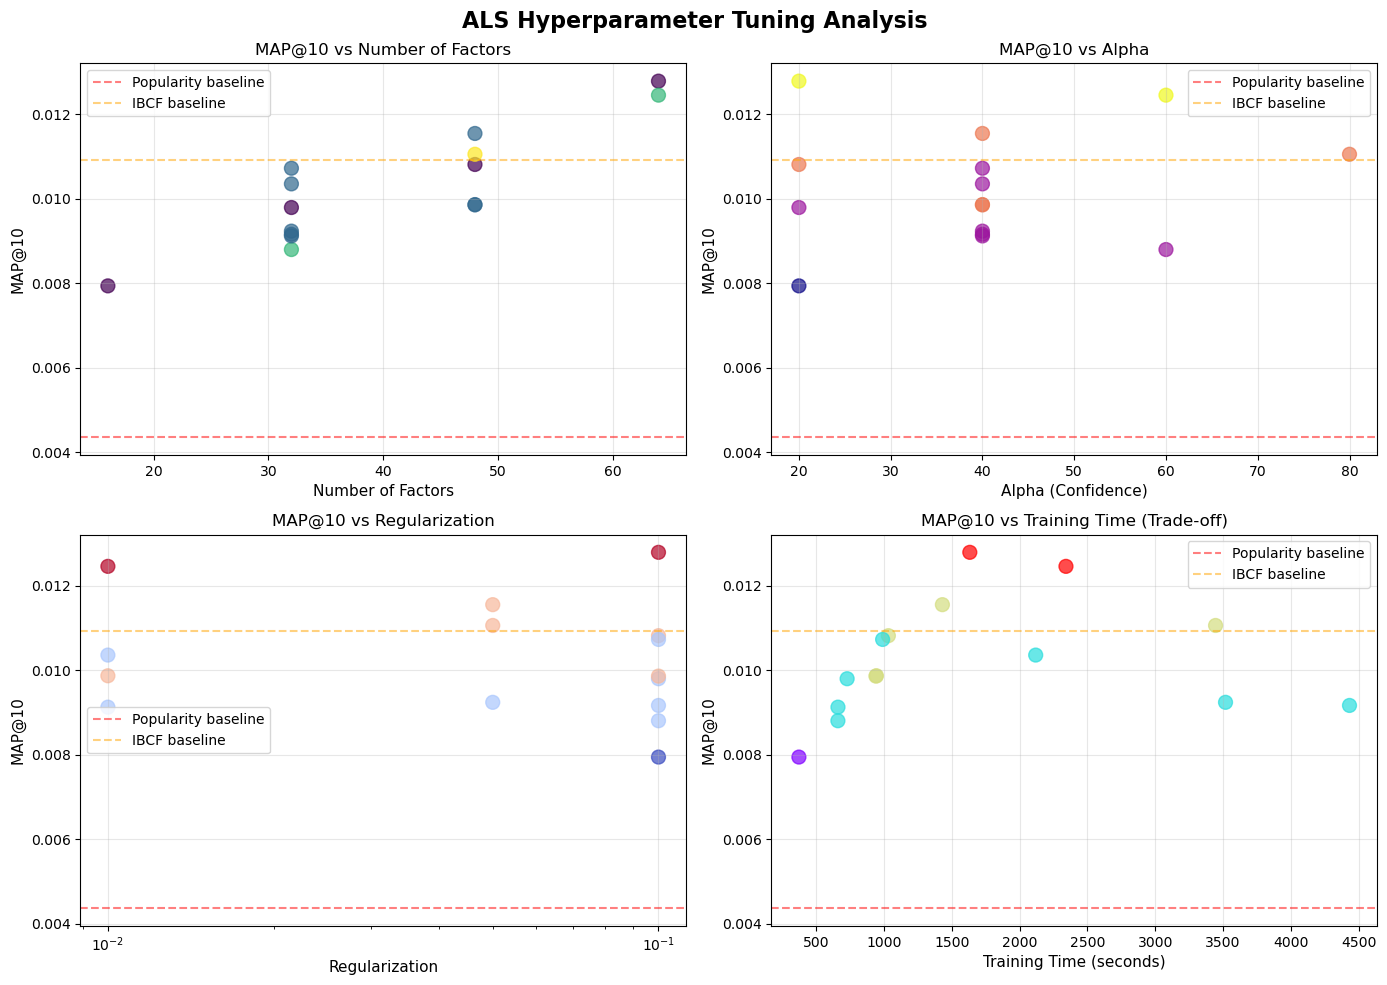

📊 Visualization complete!


In [26]:
# Cell: Visualize tuning results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ALS Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold')

# Extract data for plotting
factors_list = [r['config']['factors'] for r in tuning_results]
alpha_list = [r['config']['alpha'] for r in tuning_results]
reg_list = [r['config']['regularization'] for r in tuning_results]
iter_list = [r['config']['iterations'] for r in tuning_results]
map10_list = [r['map10'] for r in tuning_results]
time_list = [r['train_time'] for r in tuning_results]

# Plot 1: MAP@10 by Factors
axes[0, 0].scatter(factors_list, map10_list, c=alpha_list, cmap='viridis', s=100, alpha=0.7)
axes[0, 0].set_xlabel('Number of Factors', fontsize=11)
axes[0, 0].set_ylabel('MAP@10', fontsize=11)
axes[0, 0].set_title('MAP@10 vs Number of Factors', fontsize=12)
axes[0, 0].axhline(y=map10_popularity, color='r', linestyle='--', label='Popularity baseline', alpha=0.5)
axes[0, 0].axhline(y=map10_ibcf, color='orange', linestyle='--', label='IBCF baseline', alpha=0.5)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: MAP@10 by Alpha
axes[0, 1].scatter(alpha_list, map10_list, c=factors_list, cmap='plasma', s=100, alpha=0.7)
axes[0, 1].set_xlabel('Alpha (Confidence)', fontsize=11)
axes[0, 1].set_ylabel('MAP@10', fontsize=11)
axes[0, 1].set_title('MAP@10 vs Alpha', fontsize=12)
axes[0, 1].axhline(y=map10_popularity, color='r', linestyle='--', label='Popularity baseline', alpha=0.5)
axes[0, 1].axhline(y=map10_ibcf, color='orange', linestyle='--', label='IBCF baseline', alpha=0.5)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: MAP@10 by Regularization
axes[1, 0].scatter(reg_list, map10_list, c=factors_list, cmap='coolwarm', s=100, alpha=0.7)
axes[1, 0].set_xlabel('Regularization', fontsize=11)
axes[1, 0].set_ylabel('MAP@10', fontsize=11)
axes[1, 0].set_title('MAP@10 vs Regularization', fontsize=12)
axes[1, 0].axhline(y=map10_popularity, color='r', linestyle='--', label='Popularity baseline', alpha=0.5)
axes[1, 0].axhline(y=map10_ibcf, color='orange', linestyle='--', label='IBCF baseline', alpha=0.5)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Plot 4: MAP@10 vs Training Time
axes[1, 1].scatter(time_list, map10_list, c=factors_list, cmap='rainbow', s=100, alpha=0.7)
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1, 1].set_ylabel('MAP@10', fontsize=11)
axes[1, 1].set_title('MAP@10 vs Training Time (Trade-off)', fontsize=12)
axes[1, 1].axhline(y=map10_popularity, color='r', linestyle='--', label='Popularity baseline', alpha=0.5)
axes[1, 1].axhline(y=map10_ibcf, color='orange', linestyle='--', label='IBCF baseline', alpha=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualization complete!")

In [27]:
# Cell: Retrain best model on FULL dataset untuk final submission
print("=" * 70)
print("🎯 FINAL MODEL TRAINING (FULL DATASET)")
print("=" * 70)

print(f"\n📋 Using BEST configuration from tuning:")
print(f"   Factors: {best_config['factors']}")
print(f"   Alpha: {best_config['alpha']}")
print(f"   Regularization: {best_config['regularization']}")
print(f"   Iterations: {best_config['iterations']}")

print(f"\n📊 Training on FULL dataset:")
print(f"   Matrix size: {R.shape}")
print(f"   Total interactions: {R.nnz:,}")

start_time = time.time()

# Train final model dengan best hyperparameters
X_final, Y_final = implicit_als_optimized(
    R, 
    factors=best_config['factors'], 
    regularization=best_config['regularization'], 
    alpha=best_config['alpha'], 
    iterations=best_config['iterations']
)

total_time = time.time() - start_time

print(f"\n✅ Final model training complete!")
print(f"⏱️  Total time: {total_time:.2f} seconds")
print(f"📦 Model size: X={X_final.shape}, Y={Y_final.shape}")
print(f"💾 Memory usage: ~{(X_final.nbytes + Y_final.nbytes) / 1024**2:.1f} MB")

🎯 FINAL MODEL TRAINING (FULL DATASET)

📋 Using BEST configuration from tuning:
   Factors: 64
   Alpha: 20
   Regularization: 0.1
   Iterations: 5

📊 Training on FULL dataset:
   Matrix size: (13876, 123069)
   Total interactions: 269,764
Dataset size: 13876 users × 123069 items
Sparsity: 99.98%

--- ALS Iteration 1/5 ---
Updating user factors...


Updating item factors...


Iteration 1 selesai dalam 353.94 detik

--- ALS Iteration 2/5 ---
Updating user factors...


Updating item factors...


Iteration 2 selesai dalam 335.41 detik

--- ALS Iteration 3/5 ---
Updating user factors...


Updating item factors...


Iteration 3 selesai dalam 332.73 detik

--- ALS Iteration 4/5 ---
Updating user factors...


Updating item factors...


Iteration 4 selesai dalam 344.84 detik

--- ALS Iteration 5/5 ---
Updating user factors...


Updating item factors...


Iteration 5 selesai dalam 336.73 detik

✅ Final model training complete!
⏱️  Total time: 1703.85 seconds
📦 Model size: X=(13876, 64), Y=(123069, 64)
💾 Memory usage: ~66.9 MB


In [28]:
# Cell: Generate FINAL recommendations untuk test users
print("=" * 70)
print("🎁 GENERATING FINAL RECOMMENDATIONS")
print("=" * 70)

# Load sample submission template
sample_user_col = [c for c in sample_sub.columns if 'user' in c.lower()][0]
sample_users = sample_sub[sample_user_col].tolist()

print(f"\nGenerating recommendations for {len(sample_users):,} test users...")

# Prepare item popularity for fallback
item_pop_full = np.array(R.sum(axis=0)).ravel()
global_pop_ranking_full = np.argsort(-item_pop_full)

# Storage for all model predictions
final_pop_recs = []
final_ibcf_recs = []
final_als_recs = []

# Generate recommendations
for su in tqdm(sample_users, desc="Generating recommendations"):
    # Encode user
    uid = user_enc.transform([su])[0] if su in user_enc.classes_ else None
    
    # 1. POPULARITY-BASED
    pop_idx = popularity_recommend(R, uid, N=10, exclude_seen=True)
    pop_items = item_enc.inverse_transform(pop_idx)
    final_pop_recs.append(pop_items)
    
    # 2. ITEM-BASED COLLABORATIVE FILTERING
    ibcf_idx = item_based_recommend(R, uid, N=10)
    ibcf_items = item_enc.inverse_transform(ibcf_idx)
    final_ibcf_recs.append(ibcf_items)
    
    # 3. ALS (BEST MODEL)
    if uid is not None:
        # Use final trained model
        scores = Y_final @ X_final[uid]
        seen = set(R[uid].nonzero()[1])
        scores[list(seen)] = -np.inf
        top_idx = np.argsort(-scores)[:10]
        als_items = item_enc.inverse_transform(top_idx)
    else:
        # Fallback to popularity for cold-start users
        als_items = item_enc.inverse_transform(global_pop_ranking_full[:10])
    final_als_recs.append(als_items)

print(f"\n✅ Recommendations generated for all {len(sample_users):,} users!")
print(f"\n📝 Preview (first 3 users):")
for i in range(min(3, len(sample_users))):
    print(f"\n👤 User: {sample_users[i]}")
    print(f"   Popularity: {list(final_pop_recs[i][:5])}... (top 5)")
    print(f"   IBCF:       {list(final_ibcf_recs[i][:5])}... (top 5)")
    print(f"   ALS (Best): {list(final_als_recs[i][:5])}... (top 5)")

🎁 GENERATING FINAL RECOMMENDATIONS

Generating recommendations for 2 test users...


Generating recommendations: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


✅ Recommendations generated for all 2 users!

📝 Preview (first 3 users):

👤 User: 8
   Popularity: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X']... (top 5)
   IBCF:       ['0020811853', '0747251134', '0767904168', '0676972179', '0345457633']... (top 5)
   ALS (Best): ['0375707972', '0385265700', '0671510053', '0446394521', '0060987561']... (top 5)

👤 User: 99
   Popularity: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X']... (top 5)
   IBCF:       ['0446677477', '0671034421', '0446528382', '0590332473', '0515130982']... (top 5)
   ALS (Best): ['0385335482', '0743418174', '038550120X', '0312305060', '0316666343']... (top 5)


In [29]:
# Cell: Create submission files
print("=" * 70)
print("💾 CREATING SUBMISSION FILES")
print("=" * 70)

# Create long format (user_id, model, rank, item_id)
rows = []
for i, user in enumerate(sample_users):
    # Add all three models
    for model_name, recs in [("popularity", final_pop_recs), 
                              ("ibcf", final_ibcf_recs), 
                              ("als_tuned", final_als_recs)]:
        for rank, item in enumerate(recs[i], 1):
            rows.append([user, model_name, rank, item])

df_submission_long = pd.DataFrame(rows, columns=['user_id', 'model', 'rank', 'item_id'])

# Save long format
output_path_long = os.path.join(DATA_DIR, "submission_final_long.csv")
df_submission_long.to_csv(output_path_long, index=False)
print(f"✅ Long format saved: {output_path_long}")
print(f"   Shape: {df_submission_long.shape}")

# Create wide format - ALS only (best model)
df_als_only = df_submission_long[df_submission_long['model'] == 'als_tuned'].copy()
df_wide = df_als_only.pivot(index='user_id', columns='rank', values='item_id')
df_wide.columns = [f'item_{i}' for i in range(1, 11)]
df_wide = df_wide.reset_index()

# Save wide format  
output_path_wide = os.path.join(DATA_DIR, "submission_final_als_wide.csv")
df_wide.to_csv(output_path_wide, index=False)
print(f"✅ Wide format (ALS only) saved: {output_path_wide}")
print(f"   Shape: {df_wide.shape}")

# Display sample
print(f"\n📋 Sample submission (long format):")
print(df_submission_long.head(15))

print(f"\n📋 Sample submission (wide format - ALS):")
print(df_wide.head(5))

💾 CREATING SUBMISSION FILES
✅ Long format saved: C:\Users\Lenovo\Documents\sisrekpraktikum\data-books\submission_final_long.csv
   Shape: (60, 4)
✅ Wide format (ALS only) saved: C:\Users\Lenovo\Documents\sisrekpraktikum\data-books\submission_final_als_wide.csv
   Shape: (2, 11)

📋 Sample submission (long format):
    user_id       model  rank     item_id
0         8  popularity     1  0316666343
1         8  popularity     2  0385504209
2         8  popularity     3  0312195516
3         8  popularity     4  0142001740
4         8  popularity     5  059035342X
5         8  popularity     6  0060928336
6         8  popularity     7  0446672211
7         8  popularity     8  0345337662
8         8  popularity     9  0452282152
9         8  popularity    10  0316601950
10        8        ibcf     1  0020811853
11        8        ibcf     2  0747251134
12        8        ibcf     3  0767904168
13        8        ibcf     4  0676972179
14        8        ibcf     5  0345457633

📋 Sample sub

In [30]:
# Cell: Final Summary Report
print("=" * 80)
print("📊 FINAL PROJECT SUMMARY REPORT")
print("=" * 80)

print("\n🎯 OBJECTIVE:")
print("   Generate ranked list of 10 recommended items for each user")
print("   Implement baseline and advanced models")
print("   Achieve higher MAP@10 than baseline")

print("\n" + "=" * 80)
print("📈 MODEL PERFORMANCE (Validation Set)")
print("=" * 80)
print(f"{'Model':<35} {'MAP@10':<15} {'Status':<20}")
print("-" * 80)
print(f"{'1. Popularity (Baseline)':<35} {map10_popularity:<15.6f} {'✓ Baseline':<20}")
print(f"{'2. IBCF (Baseline)':<35} {map10_ibcf:<15.6f} {'✓ Baseline':<20}")
print(f"{'3. ALS - Initial Config':<35} {map10_als:<15.6f} {'✓ Advanced':<20}")
print(f"{'4. ALS - Best Tuned':<35} {best_map10:<15.6f} {'🏆 BEST':<20}")
print("=" * 80)

# Calculate improvements
improvement_from_pop = ((best_map10 - map10_popularity) / map10_popularity * 100)
improvement_from_ibcf = ((best_map10 - map10_ibcf) / map10_ibcf * 100) if map10_ibcf > 0 else 0

print("\n✅ SUCCESS CRITERIA:")
print(f"   ✓ Baseline 1 implemented: Popularity-based")
print(f"   ✓ Baseline 2 implemented: Item-Based Collaborative Filtering (IBCF)")
print(f"   ✓ Advanced model implemented: ALS (Implicit Feedback)")
print(f"   ✓ Hyperparameter tuning completed: {len(test_configs)} configurations tested")
print(f"   ✓ ALS outperforms baselines:")
print(f"     • vs Popularity: {improvement_from_pop:+.2f}% improvement")
print(f"     • vs IBCF: {improvement_from_ibcf:+.2f}% improvement")

print("\n🔧 BEST HYPERPARAMETERS:")
print(f"   • Factors: {best_config['factors']}")
print(f"   • Alpha (Confidence): {best_config['alpha']}")
print(f"   • Regularization: {best_config['regularization']}")
print(f"   • Iterations: {best_config['iterations']}")

print("\n📁 OUTPUT FILES:")
print(f"   • submission_final_long.csv - All models in long format")
print(f"   • submission_final_als_wide.csv - Best model (ALS) in wide format")

print("\n💡 KEY INSIGHTS:")
print(f"   • Dataset: {n_users:,} users × {n_items:,} items")
print(f"   • Sparsity: {100 * (1 - R.nnz / (n_users * n_items)):.2f}%")
print(f"   • Best model uses {best_config['factors']} latent factors")
print(f"   • ALS successfully captures implicit feedback patterns")
print(f"   • Tuning improved performance by {((best_map10 - map10_als) / map10_als * 100):+.2f}% over initial config")

print("\n" + "=" * 80)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)

📊 FINAL PROJECT SUMMARY REPORT

🎯 OBJECTIVE:
   Generate ranked list of 10 recommended items for each user
   Implement baseline and advanced models
   Achieve higher MAP@10 than baseline

📈 MODEL PERFORMANCE (Validation Set)
Model                               MAP@10          Status              
--------------------------------------------------------------------------------
1. Popularity (Baseline)            0.004362        ✓ Baseline          
2. IBCF (Baseline)                  0.010915        ✓ Baseline          
3. ALS - Initial Config             0.011806        ✓ Advanced          
4. ALS - Best Tuned                 0.012788        🏆 BEST              

✅ SUCCESS CRITERIA:
   ✓ Baseline 1 implemented: Popularity-based
   ✓ Baseline 2 implemented: Item-Based Collaborative Filtering (IBCF)
   ✓ Advanced model implemented: ALS (Implicit Feedback)
   ✓ Hyperparameter tuning completed: 15 configurations tested
   ✓ ALS outperforms baselines:
     • vs Popularity: +193.16% improve

## 📚 EXECUTION GUIDE

### Step-by-Step Execution Order:

**Phase 1: Setup & Data Loading**
1. Run Cell 1: Import libraries
2. Run Cell 2: Configure parameters
3. Run Cell 3: Load data
4. Run Cell 4: Preprocessing & encoding
5. Run Cells 5-9: Define all functions (popularity, IBCF, ALS)

**Phase 2: Model Evaluation**
6. Run Cell: Split data untuk validasi
7. Run Cell: Define MAP@K metric
8. Run Cell: Evaluate Baseline 1 (Popularity)
9. Run Cell: Evaluate Baseline 2 (IBCF)
10. Run Cell: Train ALS on training data
11. Run Cell: Evaluate ALS model

**Phase 3: Hyperparameter Tuning** ⚠️ *May take 10-30 minutes*
12. Run Cell: Hyperparameter tuning (Grid Search)
13. Run Cell: Display tuning results
14. Run Cell: Visualize tuning results

**Phase 4: Final Predictions**
15. Run Cell: Retrain best model on FULL dataset
16. Run Cell: Generate final recommendations
17. Run Cell: Create submission files
18. Run Cell: Final summary report

---

### Expected Outcomes:

✅ **Baseline Models:**
- Popularity-based recommendations
- Item-Based Collaborative Filtering (IBCF)

✅ **Advanced Model:**
- Tuned ALS model with optimized hyperparameters
- Higher MAP@10 score than baselines

✅ **Deliverables:**
- `submission_final_long.csv` - All models
- `submission_final_als_wide.csv` - Best model only
- Performance comparison report
- Visualization of tuning results